
# **Final Submission** 
# Challenge Naïve Bayes Detector

# PSF-PSP 2020-2021

## Grado Ingenería Biomédica - Biomedical Engineering Degree

### Universidad Rey Juan Carlos


### Authors

#### Paola Paradas, María Elena Feria, Vega Vázquez

#### May 11th, 2021

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#load data
#%matplotlib notebook
from scipy.io import loadmat
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dirfilename = {}
for dirname, _, filenames in os.walk('../input/physiological-signals-processing-challenge-2021'):
    for filename in filenames:
        a = filename
        dirfilename[a] = dirname
#print(dirfilename)

!pip install biosppy
!pip install pyrem
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The idea of working with the segments which contain the highest standard deviation comes from an adaptation of the paper '[Representation Learning Approaches to Detect False Arrhythmia Alarms from ECG Dynamics](http://https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6853621/)'. Even though we do not use any machine learning approach, we found interesting the idea of first selecting the segments with a higher probability of presenting an abnomality and then extracting useful characteristics from them.

The **dividing_segment** takes the signal and divides into several segments of 200 samples.

In [28]:
def dividing_segment(signal):
    segments = {}
    samples_in_segment=[]
    counter=0
    index=1
    for sample in signal:
        counter+=1
        samples_in_segment.append(sample)
        if counter == 2000:
            segments[index] = samples_in_segment
            index+=1
            samples_in_segment = []
            counter=0
            
    return segments

The **RR_interval** creates four dictionaries, the dictionary for rr intervals, the mean of the hear trate, the standar deviation of the hear trate and the r peaks. It iterates the dictionary containing the segments, store them in a variable which is later transformed into an array. With the hamilton segmenter function we perform the r peaks, later on we calculate the r intervals, mean and standard deviation. Those values are stored in the prior mentioned dictionaries, with each corresponding key-value

In [29]:
from biosppy.signals.ecg import hamilton_segmenter

def RR_interval(dic_segments, fs):
    dic_rr_interval = {}
    dic_mean_hr = {}
    dic_sd_hr = {}
    dic_r_peaks = {}
    for key, values in dic_segments.items():
        values = np.array(values)
        #First third of the segment
        r_peaks1 = hamilton_segmenter(values,sampling_rate = fs)
        r_peaks1 = np.array(r_peaks1[0])
        rr_interval1 = np.diff(r_peaks1)/fs * 1000
        mean_hr1 = np.mean(60/rr_interval1)
        std_hr1 = np.std(60/rr_interval1)
       
        dic_rr_interval[key] = rr_interval1
        dic_mean_hr[key]= mean_hr1
        dic_sd_hr[key]= std_hr1
        dic_r_peaks[key]= r_peaks1

        
    return dic_rr_interval, dic_mean_hr, dic_sd_hr, dic_r_peaks

The **standard_deviation** function takes the dictionary of the rr_intervals values, and it returns a dictionary.

In [30]:
def standard_deviation(dic_rr_interval):
    dic_deviation = {}
    for key, values in dic_rr_interval.items():
        standard_deviation = np.std(values,ddof=1)
        dic_deviation[key] = standard_deviation
    return dic_deviation

The **finding_maximum** function obtains the ten highest standard deviations of the heart rate.

In [31]:
def finding_maximum(standard_deviation):
    list_maximum = sorted(standard_deviation.items(), key=lambda x: x[1], reverse=True)[0:10]
    return list_maximum

The **periodogram** takes an array (signal) and compute its periodogram and the frequency at which the periodogram was computed.

In [32]:
def periodogram(x, Nfft):
    
    N = len(x)
    x_f = fft(x, Nfft) 
    Px = (np.abs(x_f)**2) / N
    Px = fftshift(Px)
    f = fftshift(fftfreq(Nfft))
    return Px, f

The **hjorth** function computes the first and the second derivate, the variance of each and the variance of the main descriptor. With these values, the activity, mobility and complexity are calculated; activity is the same as the variance of the main descriptor, mobility is the square root of the variance of the fist derivate by the variance of the main descriptor, and finally the complexity is obtained dividing the variance of the second derivate by the variance of the first derivate, this all by the mobility,

In [33]:
def hjorth(a):
    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

The **print_perio** function prints the periodogram for each id and the mean of the periodograms (black line).

In [34]:
def print_perio(list_perio, f_welch_ecg):
    #print(list_perio)
    listi=[]
    for i in range(len(list_perio)):
        try:
            h = list_perio[i].tolist()
            an_array = np.array(h)
            #print(an_array[0:10])
            #print(type(an_array))
            listi.append(an_array)
        except:
            pass
    
    PSD_x2 = np.array(listi)
    #print(type(PSD_x2))
    
    f_welch_ecg = np.mean(f_welch_ecg)

    # Convert PSD_x2 list to a Numpy array.
    plt.figure()
    Array = np.array(10*np.log10(np.mean(PSD_x2, axis=0)))
    plt.plot( f_welch_ecg, 10*np.log10(PSD_x2).T, linewidth = 0.1)    # Plot each periodogram of PSD_x2
    plt.plot( f_welch_ecg, Array,'k',linewidth = 1)  
    # Plot the mean periodogram of PSD_x2
    plt.xlim((0, f_welch_ecg[-1]))
    plt.title('Periodograms and mean periodogram of the ECG lead (only positive frequencies)')
    plt.xlabel('Normalized frequency')
    plt.ylabel('Magnitude (dB)')

The **plot_mean_feature** function performs an iteration for each value of the list indexes, which contains the position of each characteristic in the array X, it then plots the mean for each characteristic in said array.

In [35]:
def plot_mean_feature(X, indexes, fs, name_features):
    for i in indexes:
        characteristic = np.array(X[:,i])
        plt.figure()
        plt.plot(characteristic)
        plt.title(name_features[i-1])

The **print_features_hr** performs either the plot for the mean or the standard deviation of the heart rate, data that comes from the generic list of heart rates (list_hr).

In [36]:
def print_features_hr(list_hr, title):
    
    final_list=[]
    for dic in list_hr:
        data = list(dic.values())
        final_list.append(data)
        
    list_mean=[]
    for listi in final_list:
        rr = np.mean(listi)
        list_mean.append(rr)
        
    std = np.array(list_mean)
    plt.figure(figsize = (15,7))
    plt.plot(std)
    plt.title(title)

The **print_rr_interval** calculates the mean of the RR intervals of each of the IDs.

In [37]:
def print_rr_interval(list_rr_interval, title):
    final1_list=[]
    for dic in list_rr_interval:
        data = list(dic.values())
        #print(data)
        final2_list=[]
        for i in data:
            #print(data)
            data = list(data)
            an_array = np.array(data)
            an_array1 = an_array.ravel()
            an_array1 = list(an_array1)
            if len(an_array1)!=0:
                final1_list.append(an_array1)

    list_mean=[]
    for listi in final1_list:
        #std = np.array(final1_list)
        rr = np.mean(listi)
        list_mean.append(rr)
    
    array_mean = np.array(list_mean)

    
    #print(std[0:10])
    plt.figure(figsize = (15,7))
    plt.plot(array_mean)
    plt.title(title)
        #plt.figure()
        #plt.plot(60*1000/listOfpeaks)

The **plot_hist_and_p_value** iterates the array X for false and true indexes, it then plots the histogram for both for each characteristic. With a confidence value of 0.1, we perform the p value and test statistics for each one of the characteristics, if the absolute value of the test statistics is greater than the threshold we achieve to reject the null hypothesis. On the contrary, if it is smaller, we failed to reject the null hypothesis.

In [38]:
from scipy.stats import ttest_ind
from scipy.stats import t, sem, norm

# your code here
# ...

# observations

def plot_hist_and_p_value(X, indexes, index_true, index_false, name_features):
    plt.figure(figsize = (15,7))
    for i in indexes:
        x1 = X[np.array(index_false -1,dtype = int), i]
        #print(x1)
        x2 = X[np.array(index_true -1,dtype = int),  i]
        #print(x2)
        
        plt.subplot(3,3,i)
        plt.hist(x1, density = True, bins = 10)
        plt.hist(x2, density = True, bins = 10, color = 'red', alpha = 0.75)
        
        t_statistic, p_value = ttest_ind(x1, x2, equal_var = False)
        print(p_value)

        n1 = len(x1)
        n2 = len(x2)

        s12 = (np.std(x1, ddof=1))**2
        s22 = (np.std(x2, ddof=1))**2

        x1 = np.mean(x1)
        x2 = np.mean(x2)

        alpha = 0.1

        t_statistic = (x1-x2)/ np.sqrt(s12/n1 + s22/n2)
        d = (s12/n1 + s22/n2)**2 / ((s12/n1)**2/(n1-1)+(s22/n2)**2/(n2-1))
        print(d)

        th = t(df=d).ppf(1-alpha/2)
        
        print('The conclusions drawn about the characteristic: ', name_features[i-1])
        if np.abs(t_statistic)> th:
            print('We reject the null hypothesis H0')
        else:
            print('We failed to reject the null hypothesis H0')
        
        p_value = 2*(1-t(df = d).cdf(t_statistic))
        print(p_value)
        print()
        
plt.show()

The **extracting_characteristics** function which returns the standard deviation of the maxima of the instantaneous frequency; the hjorth descriptors of activity, mobility and complexity; the ratio between the average total power in the frequency band between 5 and 25 Hz and the average total power for each half of the envelope; the standard deviation of the heart rate; the standard deviation of the abp and pleth signals (in case the patient has these two); and it also returns some other important features such as dic_mean_hr, dic_std_hr, dic_rr_interval and the sampling frequency, that are going to be used to plot the corresponding histograms, periodogram and plots.


The **Welch's method** is applied to compute the PSD in the first and in the second half of the mean of heartrate template. Later, from these values the ratio between the average power on the QRS band ($\approx 5-25 $ Hz) and the total average power is computed individually for each one of the halves.


In [39]:
from biosppy.signals.ecg import extract_heartbeats 

from scipy import signal
from scipy.signal.windows import *
import pyrem as pr
from numpy.fft import *

def extracting_characteristics(pat, header, plot_flag = True):
    #ECG leads in the training set
    ecg_lead = ['I', 'II', 'III', 'MCL','V','aVF', 'aVL','aVR']

    #get fs
    fs = int(header[0].split()[2]) #hz

    #number of signals
    num_signals = int(header[0].split()[1])
    #get labels
    labels = []
    for signal1 in header[1:]:
    #split the string and get the last which is the label
        labels.append(signal1.split()[-1])
        

    #get signals
    signals = pat['val']

   #find the ECG signals
    idx_ecg = [labels.index(i) for i in ecg_lead if i in labels]
        
    
    dic_segments = dividing_segment(signals[idx_ecg[0],-2500:])
    dic_rr_interval, dic_mean_hr, dic_std_hr, dic_r_peaks = RR_interval(dic_segments, fs)
    std = standard_deviation(dic_rr_interval)
    max_values = finding_maximum(std)
  

    indexes = []
    for pair in max_values:
        #print(pair)
        indexes.append(pair[0])

    dic_final = {} #dictionary where 750 samples of each one of the 10 highest standard deviation are saved.
    for index in indexes:
        dic_final[index] = dic_segments[index]
    
    index_seg = []
    for key, value in dic_final.items():
        index_seg.append(key)
        
    segment_high_std = np.array(dic_final[index_seg[0]])
    mean_hr_segment_high_std = dic_mean_hr[index_seg[0]]
    std_hr = dic_std_hr[index_seg[0]]
    #plt.plot(segment_high_std)
    
    
    templates, rpeakst = extract_heartbeats(signal=signals[idx_ecg[0],-2500:], rpeaks=dic_r_peaks[index_seg[0]], sampling_rate=fs, before=0.2, after=0.4)
    template = np.mean(templates,axis = 0)
    #plt.plot(template)
    
    activity, mobility, complexity = hjorth(signals[idx_ecg[0],-2500:])

    try:
        f_welch_ecg1, Px_welch_ecg1 = signal.welch(template[:int(template.size/2)], fs=fs, window = 'hamming', nperseg=275, nfft=1024)
        f_welch_ecg2, Px_welch_ecg2 = signal.welch(template[int(template.size/2):], fs=fs, window = 'hamming', nperseg=275, nfft=1024)
        #print(f_welch_ecg1.size, Px_welch_ecg1.size)
        
        width = np.diff(f_welch_ecg1)
        pvec_total_1 = np.multiply(width,Px_welch_ecg1[0:-1])
        avgp_total_1 = np.sum(pvec_total_1);  
        
        pvec_total_2 = np.multiply(width,Px_welch_ecg2[0:-1])
        avgp_total_2 = np.sum(pvec_total_2); 
        
        ## Compute the average power on the alpha band for each segment.
        f_low_index1 = (np.abs(f_welch_ecg1-5)).argmin()    # Compute the index that corresponds (or is close) to f=5 Hz
        f_high_index1 = (np.abs(f_welch_ecg1-25)).argmin()  # Compute the index that corresponds (or is close) to f=25 Hz
        
        f_low_index2 = (np.abs(f_welch_ecg2-5)).argmin()    # Compute the index that corresponds (or is close) to f=5 Hz
        f_high_index2 = (np.abs(f_welch_ecg2-25)).argmin()  # Compute the index that corresponds (or is close) to f=25 Hz

        pvec_1 = np.multiply(width[f_low_index1:f_high_index1], Px_welch_ecg1[f_low_index1:f_high_index1])
        avgp_1 = np.sum(pvec_1);     # Average power on the QRS band for the 1st segment.
        r_aver_power1 = avgp_1/avgp_total_1;   # QRS-band power vs total average power ratio for the 1st segment.
        
        pvec_2 = np.multiply(width[f_low_index2:f_high_index2], Px_welch_ecg2[f_low_index2:f_high_index2])
        avgp_2 = np.sum(pvec_2);     # Average power on the QRS band for the 2nd segment.
        r_aver_power2 = avgp_2/avgp_total_2;   # QRS-band power vs total average power ratio for the 2nd segment.
    except:
        r_aver_power1 = 0
        r_aver_power2 = 0
        f_welch_ecg1 = 0
        Px_welch_ecg1 = 0
        f_welch_ecg2 = 0
        Px_welch_ecg2 = 0
        
    analytic_signal = signal.hilbert(signals[idx_ecg[0],-2500:])
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)
    
    std_inst_freq = np.std(instantaneous_frequency)
    segment_high_stdd = instantaneous_frequency
    segment_high_stddprime = np.diff(segment_high_stdd)
    sig_segment_high_stddprime = np.sign(segment_high_stddprime)
    sig_segment_high_std_two_prime = np.diff(sig_segment_high_stddprime)
    maxima = np.squeeze(np.where(sig_segment_high_std_two_prime<0))
    minima = np.squeeze(np.where(sig_segment_high_std_two_prime>0))
    std_maxima = np.std(maxima)
    
    std_abp = 0
    std_pleth = 0
    
    if ('ABP' in labels) and ('PLETH' in labels):
        #print('hole')
        pindex = {}
        for i in range(len(labels)):           
            if labels[i] == 'PLETH':
                pindex['PLETH']= i
            if  labels[i] == 'ABP':
                 pindex['ABP']= i
        
        std_abp = np.std(signals[pindex['ABP'],-2500:])
        std_pleth = np.std(signals[pindex['PLETH'],-2500:])
           
    if 'ABP' in labels:
        for i in range(len(labels)):                
            if labels[i] == 'ABP':
                pabp = i  
        std_abp = np.std(signals[pabp,-2500:])
        
        ecg_with_abp = np.array([signals[pabp,:]]+[signals[idx_ecg[0],:]])
        u,s,v = np.linalg.svd(ecg_with_abp,full_matrices=False)
        #print(ecg_with_abp)
 
    if 'PLETH' in labels:
        for i in range(len(labels)):                
            if labels[i] == 'PLETH':
                ppleth = i  
        std_pleth = np.std(signals[ppleth,-2500:])
        
    return   std_maxima, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth, f_welch_ecg1, Px_welch_ecg1, f_welch_ecg2, Px_welch_ecg2, dic_mean_hr, dic_std_hr, dic_rr_interval, fs

It orders the ids in the filename. Later on, we iterate in the dictionary. We append the values of the welch periodogram in time and frequency to each corresponding list as well as the standard deviation of the heart reat and the rr intervals. We also append the values of the characteristics obatained from the extracting_characteristics function to the X array.

In [40]:
#get into de data folder
from IPython.display import display, clear_output

X = []

for dirname, _, filenames in os.walk('/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/training/'):
    filenames.sort()
    j = 0
    #crear lista para periodograma de la primera mitad 
    list_perio_1=[]
    list_freq1=[]
    #crear lista para periodograma de la segunda mitad 
    list_perio_2=[]
    list_freq2=[]
    #Crear lista para la mean
    list_mean_hr = []
    #lista de la std
    list_std_hr = []
    #lista de la rr
    list_rr_interval = []
    for filename in filenames[:]:
        #print(filename)
        
        #if j%5==0:
            #clear_output(wait = True)
            #print(j," of ",len(filenames)/2)
            #print(filename)
            #pass
        if 'mat' in filename:
            continue
        #
        #read the pat data
        j+=1
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        #print(record)
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()

        std_inst_freq, activity, complexity, mobility, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth, f_welch_ecg1, Px_welch_ecg1, f_welch_ecg2, Px_welch_ecg2, dic_mean_hr, dic_std_hr, dic_rr_interval, fs = extracting_characteristics(record,header,plot_flag = True)
        #apppend valores a las listas correspondientes 
        list_perio_1.append(Px_welch_ecg1)
        list_freq1.append( f_welch_ecg1)
        list_perio_2.append(Px_welch_ecg2)
        list_freq2.append(f_welch_ecg2)
        list_mean_hr.append(dic_mean_hr)
        list_std_hr.append(dic_std_hr)
        list_rr_interval.append(dic_rr_interval)
        
        X.append([int(filename[:-4]), std_inst_freq, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth])
        
#print(X[:3])
for index1, array in enumerate(X[:]):
    for index2, element in enumerate(array):
        try:
            i = int(element)
        except:
            X[index1][index2] = 0
        
#Matrix X
X = np.array(X)
print(X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


[[ 1.00000000e+00  7.55940376e+02 -9.75280800e+02 ...  9.86017571e-03
   0.00000000e+00  1.26837752e+03]
 [ 1.00000000e+01  7.64386933e+02 -3.75274960e+03 ...  3.79480297e-02
   0.00000000e+00  1.25571353e+03]
 [ 1.00000000e+02  7.28822577e+02  6.96552000e+02 ...  5.54082777e-02
   0.00000000e+00  1.30963916e+03]
 ...
 [ 9.70000000e+01  7.35585333e+02  3.82594080e+03 ...  1.21343603e-03
   1.18379721e+03  1.17763065e+03]
 [ 9.80000000e+01  8.07816828e+02  8.21924800e+02 ...  5.43440247e-02
   0.00000000e+00  1.37498487e+03]
 [ 9.90000000e+01  7.26037083e+02  3.20676800e+02 ...  2.16423175e-01
   1.26076353e+03  0.00000000e+00]]


This piece of code loads from the csv the alarms (true and false) and the y_train trains the values that we're going to be using down below

In [41]:
#Get labels for the patients
y = np.loadtxt('/kaggle/input/physiological-signals-processing-challenge-2021/alarms_training.csv',skiprows=1,delimiter = ',',usecols = [0,1])

#print(y.shape)
#print(y[:2])
#print(X)

#X = np.array(X)
#print(X[:,0]) #Todas las columnas en la posición zero (0)
#print(type(X[:,0]))
#print(np.array(X[:,0]-1,dtype = int))
y_train = y[np.array(X[:,0]-1,dtype = int),:]

This function classifies the obtained indexes from the IDs into true or false.

In [42]:
y_train = y[np.array(X[:,0]-1,dtype = int),:]
print(y_train.shape)


print(X[1,0])
print(y_train[1,0])

index_false = []
index_true = []
for index, item in enumerate(y_train):
    #print(item[1])
    if item[1] == 0:
        index_false.append(index)
    elif item[1] == 1:
        index_true.append(index)
        
index_false = np.array(index_false)
index_true = np.array(index_true)
    
#print(index_false)
#print(index_true)

(550, 2)
10.0
10.0


We get priors, and we separate the signals depending on the lead of origin. Four dictionaries are filled with each type of signal, ecg signal, both pleth and abp signals, abp signals and pleth signals. For each characteristic, if the standard deviation of abp and pleth is different from 0 then we fill the both dictionary. If the standard deviation of abp is different from 0 we fill the dictionary with the values of the characteristics, finally, if the standard deviation of pleth is different from 0 we fill the dictionary with the values of the characteristics

In [43]:
#Create naive bayes
from sklearn.naive_bayes import GaussianNB

#get priors
P_h0 = np.mean(y_train[:,1] == 0)
P_h1 = np.mean(y_train[:,1] == 1)

print('P_h0:',P_h0,'; P_h1:',P_h1)

#naive bayes model
dic_ecg = {}
dic_both = {}
dic_abp = {}
dic_pleth = {}

index = 0
for std_maxima, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth in X[:,1:]:
    #print(std_hr1)
    dic_ecg[X[index][0]] = X[index][1:8]
    if std_abp != 0 and std_pleth  != 0:
        dic_both[X[index][0]] = X[index][1:10]#Modificar desde aquí
    elif std_abp != 0:
        dic_abp[X[index][0]] = X[index][1:9]
    elif std_pleth  != 0:
        dic_pleth[X[index][0]] = np.array([r_aver_power1]+[r_aver_power2]+[activity]+[mobility]+[complexity]+[std_hr]+[std_pleth])
   
    index += 1

P_h0: 0.6145454545454545 ; P_h1: 0.38545454545454544


This portion of code saves into a list the IDs and into another one the index of each of the IDs belonging to either :abp, pleth, both or ecg.

In [44]:
ids_ecg=[]
for number in dic_ecg.keys():
    ids_ecg.append(number)
    
ids_both=[]
for number in dic_both.keys():
    ids_both.append(number)
    
ids_abp=[]
for number in dic_abp.keys():
    ids_abp.append(number)

ids_pleth=[]
for number in dic_pleth.keys():
    ids_pleth.append(number)
    
index_ecg=[]
index_both=[]
index_abp=[]
index_pleth=[]
for index, value in enumerate(X[:,0]):
    if value in ids_ecg:
        index_ecg.append(index)
    if value in ids_both:
        index_both.append(index)
    if value in ids_abp:
        index_abp.append(index)
    if value in ids_pleth:
        index_pleth.append(index)

For each type of signal, we train the model with Naives Bayes detector, we contemplate ecg only, abp only, pleth only, and pleth plus abp cases. Using the dictionaries with the values of each type of signals, it performs a list and then the array for those values in each case that is later used in the training calculations

In [45]:
### train the model

index_ecg = np.array(index_ecg)
index_both = np.array(index_both)
index_abp = np.array(index_abp)
index_pleth = np.array(index_pleth)

#Detector ecg only
nb_detector_ecg = GaussianNB(priors = [P_h0,P_h1])
nb_detector_ecg.fit(X[np.array(index_ecg,dtype = int),1:8],y_train[np.array(index_ecg,dtype = int),1])

print("mean values n_classes, n_feauters")
print(nb_detector_ecg.theta_)
print("variance values n_classes, n_feauters")
print(nb_detector_ecg.sigma_)

#Detector ABP+PLETH

nb_detector_both = GaussianNB(priors = [P_h0,P_h1])
#print(X[np.array(index_both,dtype = int),7:9])
nb_detector_both.fit(X[np.array(index_both,dtype = int),1:10],y_train[np.array(index_both,dtype = int),1])

print("mean values n_classes, n_feauters")
print(nb_detector_both.theta_)
print("variance values n_classes, n_feauters")
print(nb_detector_both.sigma_)

#Detector ABP
nb_detector_abp = GaussianNB(priors = [P_h0,P_h1])
data1 = list(dic_abp.values())
#print(data1)
abp = np.array(data1)
#print(abp)

nb_detector_abp.fit(X[np.array(index_abp,dtype = int),1:9],y_train[np.array(index_abp,dtype = int),1])

print("mean values n_classes, n_feauters")
print(nb_detector_abp.theta_)
print("variance values n_classes, n_feauters")
print(nb_detector_abp.sigma_)
    

#Detector ECG+PLETH

nb_detector_pleth = GaussianNB(priors = [P_h0,P_h1])
#print(dic_pleth.values())
data2 = list(dic_pleth.values())
pleth = np.array(data2)
print(pleth[0])

nb_detector_pleth.fit(pleth,y_train[np.array(index_pleth,dtype = int),1])

print("mean values n_classes, n_feauters")
print(nb_detector_pleth.theta_)
print("variance values n_classes, n_feauters")
print(nb_detector_pleth.sigma_)

mean values n_classes, n_feauters
[[7.19215271e+02 7.39269383e+02 5.77248892e-01 1.41238281e+00
  6.63763346e-01 3.61667796e-01 3.83765054e-02]
 [7.42430352e+02 4.58162225e+02 4.13268986e-01 1.25219197e+00
  6.89387668e-01 3.64476958e-01 4.35166648e-02]]
variance values n_classes, n_feauters
[[1.83657858e+04 2.32327278e+06 1.88814669e+00 1.86332069e+00
  5.75563412e-02 4.08386818e-02 1.14342598e-02]
 [7.72404332e+02 3.18379012e+06 3.05212861e-01 2.88209507e+00
  3.86983479e-02 3.58982780e-02 4.09865715e-02]]
mean values n_classes, n_feauters
[[7.18717014e+02 1.06394958e+03 6.19644009e-01 1.54094673e+00
  6.94070907e-01 3.67888156e-01 3.21197419e-02 1.11928063e+03
  1.28295098e+03]
 [7.57284913e+02 1.21172681e+03 4.97974646e-01 1.35307834e+00
  6.60895171e-01 3.80623266e-01 3.87023761e-02 1.15753173e+03
  1.25685221e+03]]
variance values n_classes, n_feauters
[[1.78303880e+04 1.39632260e+06 7.46791211e-01 2.00768640e+00
  5.43602523e-02 4.37913953e-02 4.04796207e-03 1.91784595e+05
  1.4

In [46]:
#predict first case
from sklearn.metrics import f1_score
x_1 = dic_ecg[1]
D = nb_detector_ecg.predict(x_1[np.newaxis,:])

print(X[0,0])
print(y_train[0,0])
print('Detection: %d'%D[0])
print('Hypothesis H: %d' %y_train[0,1])# Del index 0 la posición 1

#whole training set
#print(X[:,0])
y_hat = {}
for index, ids in enumerate(X[:,0]):
    list_y_hat = []
    x_1 = dic_ecg[ids]
    list_y_hat.append(nb_detector_ecg.predict(x_1[np.newaxis,:]))
    if index in index_both:
        x_1 = dic_both[ids]
        list_y_hat.append(nb_detector_both.predict(x_1[np.newaxis,:]))
    elif index in index_abp:
        x_1 = np.array([dic_abp[ids]])
        x_1 = x_1[0]
        list_y_hat.append(nb_detector_abp.predict(x_1[np.newaxis,:]))
    elif index in index_pleth:
        x_1 = np.array([dic_pleth[ids]])
        x_1 = x_1[0]
        #print('pleth', x_1)
        list_y_hat.append(nb_detector_pleth.predict(x_1[np.newaxis,:]))
        
    if np.mean(list_y_hat)>=0.5:
        y_hat[index] = 1.
    else:
        y_hat[index] = 0.
        
#print(y_hat)        
data = list(y_hat.values())
an_array = np.array(data)

y_hat = an_array.flatten()
#print(y_hat)       
print('ACC = %.2f'%np.mean(y_hat == y_train[:,1]))#Todos en la posición 1
print('f1 score = %.2f'%f1_score(y_train[:,1], y_hat))

1.0
1.0
Detection: 1
Hypothesis H: 1
ACC = 0.47
f1 score = 0.57


This code is used to call the previous functions, whose functions is to plot the mean of the heart rate, the mean of the periodogram, the standard deviation of the heart rate, the mean of the heart rate and the rr intervals

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


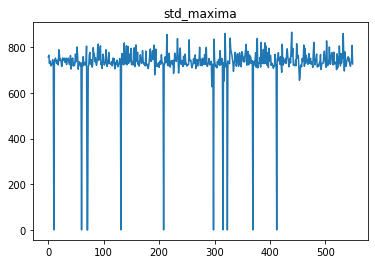

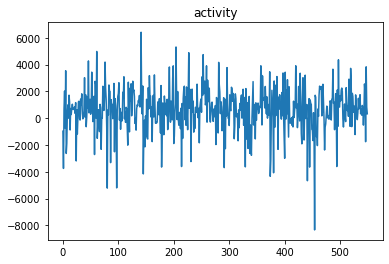

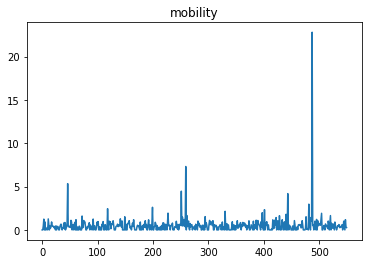

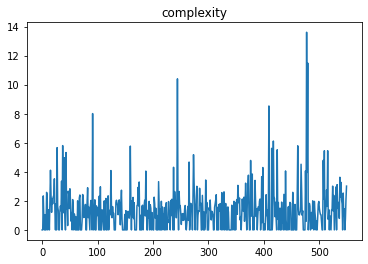

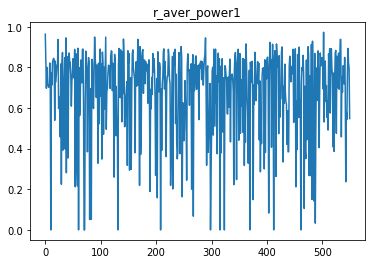

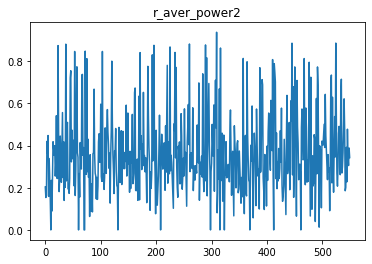

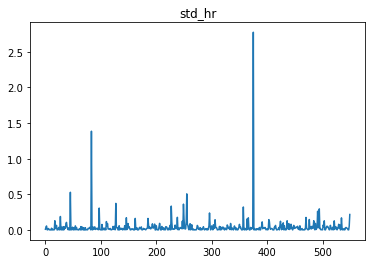

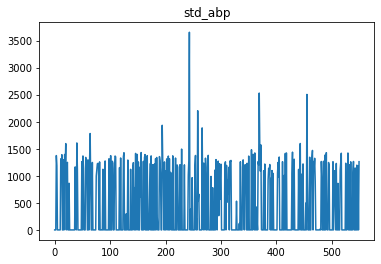

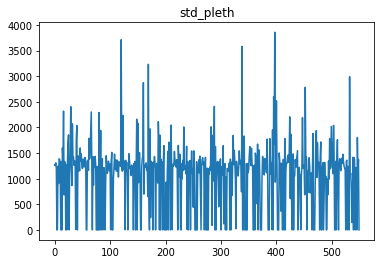

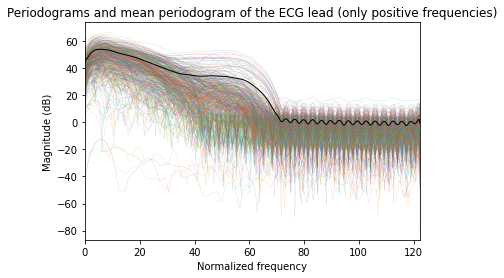

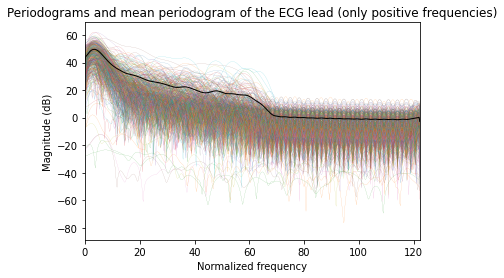

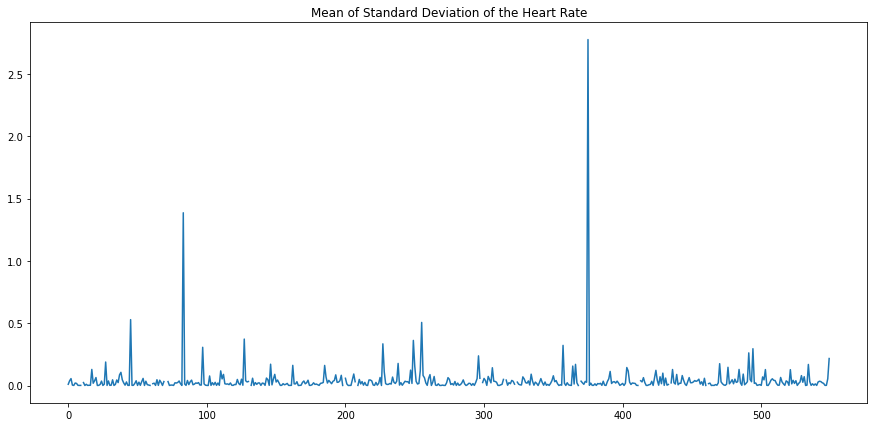

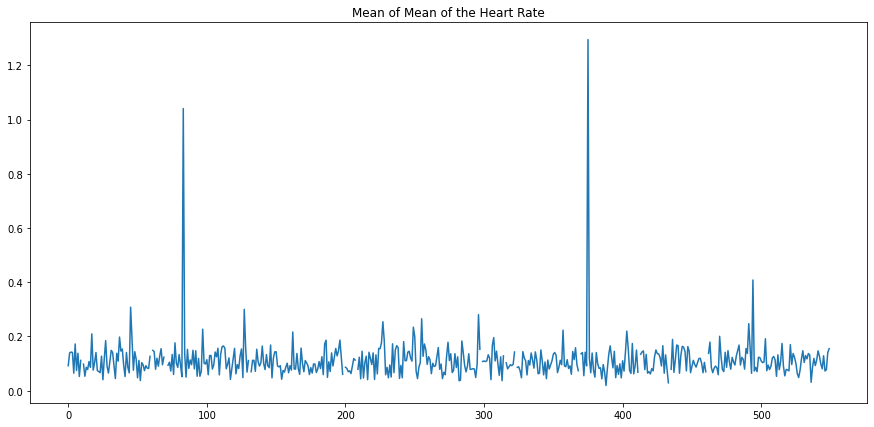

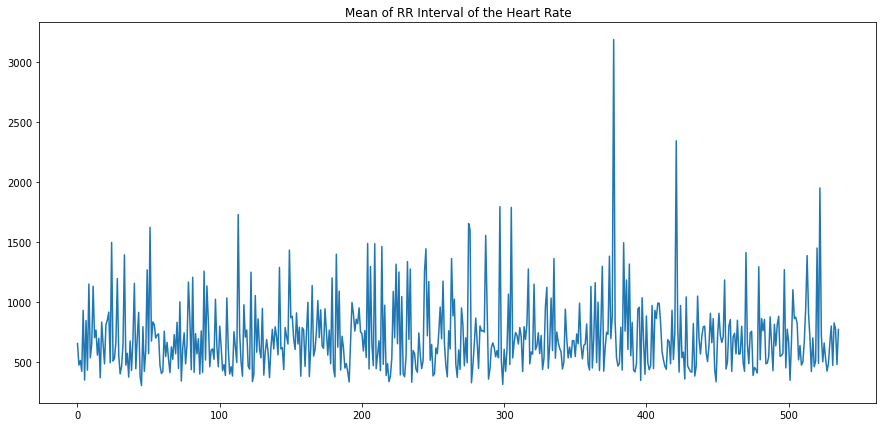

In [47]:
indexes = [1,2,3,4,5,6,7,8,9]
name_features = ['std_maxima', 'activity', 'mobility', 'complexity', 'r_aver_power1', 'r_aver_power2', 'std_hr', 'std_abp', 'std_pleth']
#fs = 250
mean_feature = plot_mean_feature(X, indexes, fs, name_features)

perio1 =  print_perio(list_perio_1, list_freq1)
perio2 = print_perio(list_perio_2, list_freq2)

std_hr = print_features_hr(list_std_hr, 'Mean of Standard Deviation of the Heart Rate')

mean = print_features_hr(list_mean_hr, 'Mean of Mean of the Heart Rate')

rr = print_rr_interval(list_rr_interval, 'Mean of RR Interval of the Heart Rate')

Call the **plot_hist_and_p_value** function.

0.42431067532701916
516.6905601342281
The conclusions drawn about the characteristic:  std_maxima
We failed to reject the null hypothesis H0
1.5756893246729806

0.0617364876226796
463.21123885259345
The conclusions drawn about the characteristic:  activity
We reject the null hypothesis H0
1.9382635123773204

0.9222275082660345
492.74770585902064
The conclusions drawn about the characteristic:  mobility
We failed to reject the null hypothesis H0
0.9222275082660345

0.3394642550670862
426.1161405577891
The conclusions drawn about the characteristic:  complexity
We failed to reject the null hypothesis H0
1.660535744932914

0.9786039546228291
472.9958165918732
The conclusions drawn about the characteristic:  r_aver_power1
We failed to reject the null hypothesis H0
1.0213960453771709

0.7817284312765388
474.4259188721803
The conclusions drawn about the characteristic:  r_aver_power2
We failed to reject the null hypothesis H0
0.7817284312765387

0.832024872317539
536.590351673706
The conclus

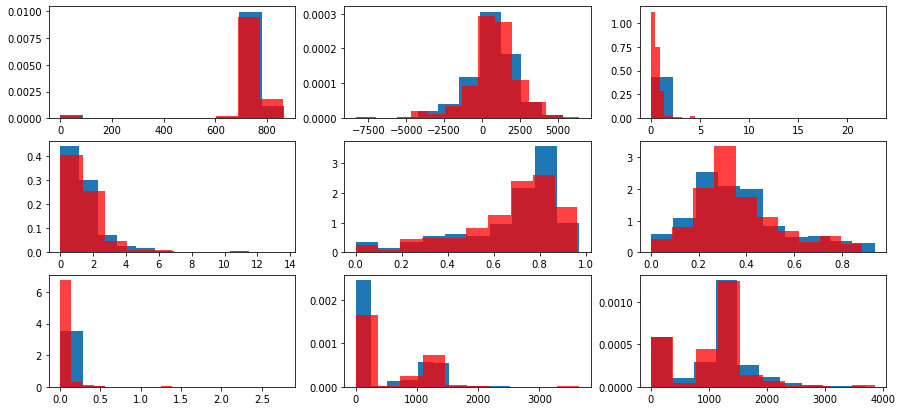

In [48]:
#plot_hist_and_p_value()

plot_hist_and_p_value(X, indexes, index_true, index_false, name_features)

Our hypothesis are H0: False alarm, H1: True alarm. 
* The priors **P_h0** and **P_h1** were computed by taking the mean of the number of times a false (for **P_h0**) and a true alarm (for **P_h1**) appears inside **y_train**. 
* A naïf Bayes detector was applied to identified whether or not each recording in the test folder corresponds to a true or a false alarm. This detector assumes that likelihoods or conditioned characteristics are independent, meaning that $$p(x_1,\ldots,x_n|H_0)=p(x_1|H_0)p(x_2|H_0)\cdots p(x_n|H_0)$$ and $$p(x_1,\ldots,x_n|H_1)=p(x_1|H_1)p(x_2|H_1)\cdots p(x_n|H_1)$$


The following piece of code repeats the same procedure applied before for each ID in the test file.

In [49]:
X_test = []

for dirname, _, filenames in os.walk('/kaggle/input/physiological-signals-processing-challenge-2021/data_challenge/test/'):
    filenames.sort()
    j = 0
    
    list_perio_1=[]
    list_freq1=[]
   
    list_perio_2=[]
    list_freq2=[]
    
    list_mean_hr = []
    
    list_std_hr = []
    
    list_rr_interval = []
    for filename in filenames:

            
        if 'mat' in filename:
            continue
        #
        j+=1
        #read the pat data
        record = loadmat(os.path.join(dirname,filename[:-4]+'.mat'))
        
        #get the header
        with open(os.path.join(dirname,filename)) as f:
                header = f.readlines()

        #pass to the function to get the mean and std heart rate
        
        std_maxima, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth, f_welch_ecg1, Px_welch_ecg1, f_welch_ecg2, Px_welch_ecg2, dic_mean_hr, dic_std_hr, dic_rr_interval, fs  = extracting_characteristics(record,header,plot_flag = True)
        #apppend valores a las listas correspondientes 
        list_perio_1.append(Px_welch_ecg1)
        list_freq1.append( f_welch_ecg1)
        list_perio_2.append(Px_welch_ecg2)
        list_freq2.append(f_welch_ecg2)
        list_mean_hr.append(dic_mean_hr)
        list_std_hr.append(dic_std_hr)
        list_rr_interval.append(dic_rr_interval)
        
        X_test.append([int(filename[:-4]), std_maxima, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth])

for index1, array in enumerate(X_test[:]):
    for index2, element in enumerate(array):
        try:
            i = int(element)
        except:
            X_test[index1][index2] = 0
#print(X_test)

/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 275 is greater than input length  = 75, using nperseg = 75
  .format(nperseg, input_length))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/si

In [50]:
#sort data
X_test = np.array(X_test)

idx_sort = np.argsort(X_test[:,0])

X_test = X_test[idx_sort,:]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


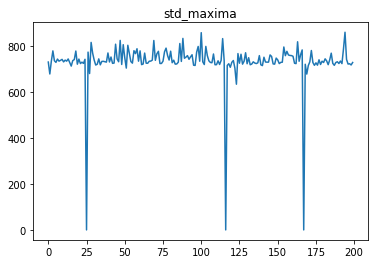

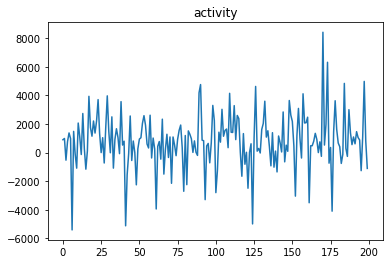

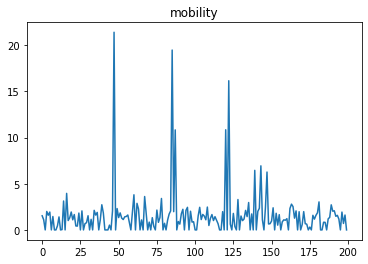

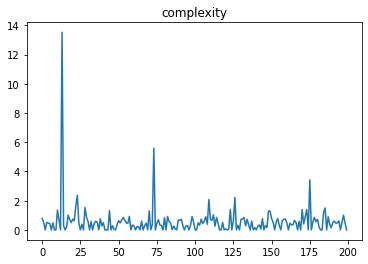

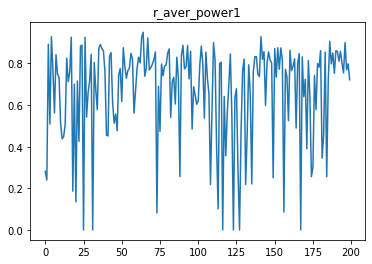

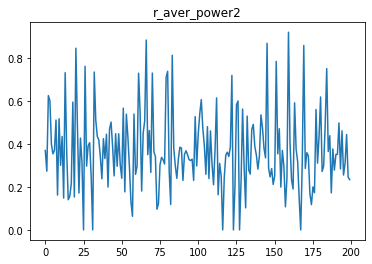

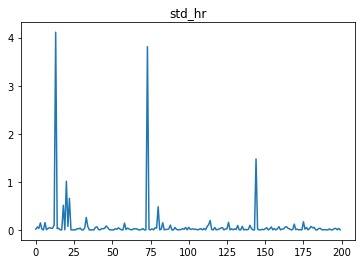

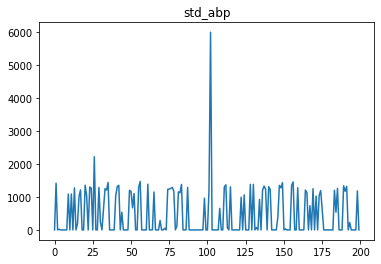

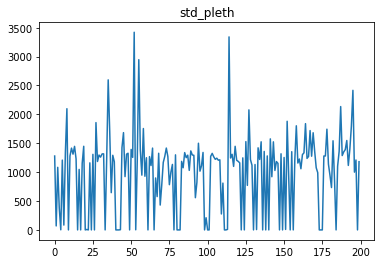

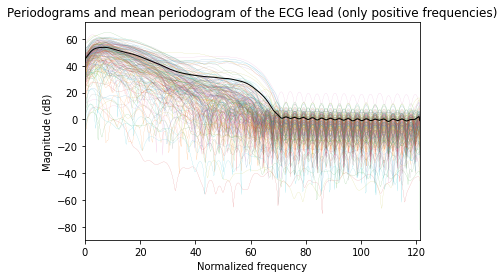

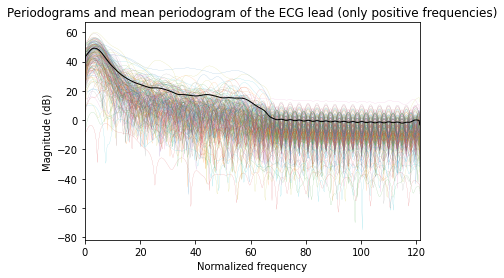

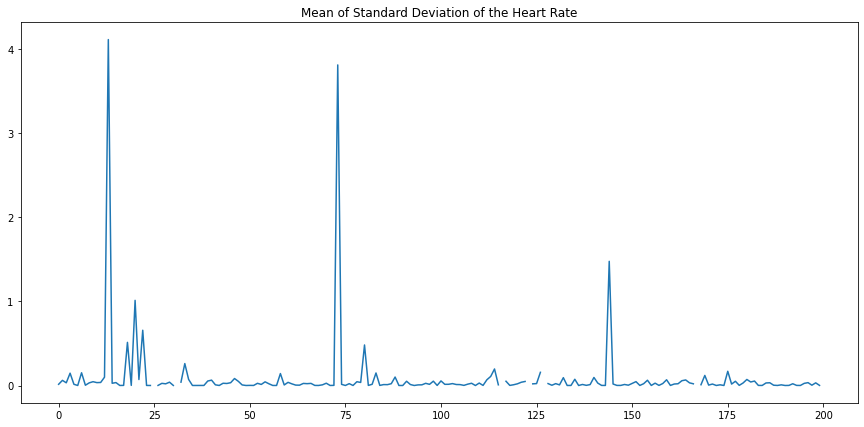

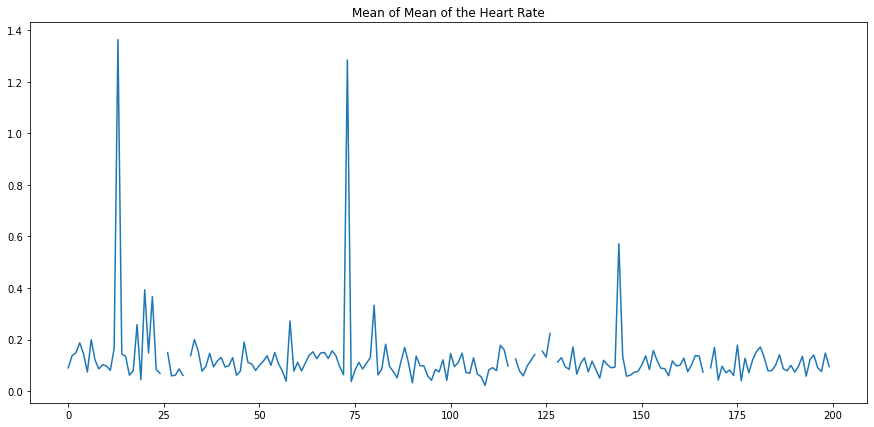

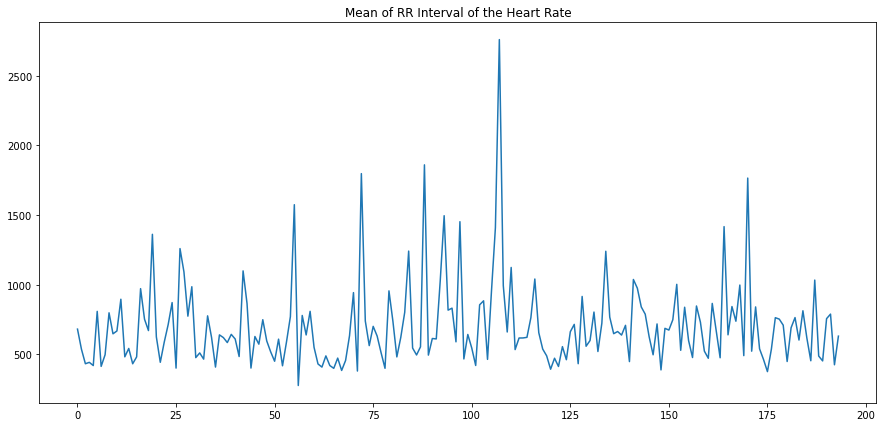

In [51]:
#plot_mean_feature()
#indexes = [1,2,3,4,5,6,7]
mean_feature = plot_mean_feature(X_test, indexes, fs, name_features)

perio1 =  print_perio(list_perio_1, list_freq1)
perio2 = print_perio(list_perio_2, list_freq2)

std_hr = print_features_hr(list_std_hr, 'Mean of Standard Deviation of the Heart Rate')

mean = print_features_hr(list_mean_hr, 'Mean of Mean of the Heart Rate')

rr = print_rr_interval(list_rr_interval, 'Mean of RR Interval of the Heart Rate')

In [52]:
dic_ecg = {}
dic_both = {}
dic_abp = {}
dic_pleth = {}

index = 0
for std_maxima, activity, mobility, complexity, r_aver_power1, r_aver_power2, std_hr, std_abp, std_pleth in X_test[:,1:]:
    #print(std_hr1)
    dic_ecg[X_test[index][0]] = X_test[index][1:8] 
    if std_abp != 0 and std_pleth != 0:
        dic_both[X_test[index][0]] = X_test[index][1:10]
    if std_abp != 0:
        dic_abp[X_test[index][0]] = X_test[index][1:9]
    if std_pleth != 0:
        dic_pleth[X_test[index][0]] = np.array([r_aver_power1]+[r_aver_power2]+[activity]+[mobility]+[complexity]+[std_hr]+[std_pleth])
        

    index += 1
#print(dic_ecg)

In [53]:
ids_ecg=[]
for number in dic_ecg.keys():
    ids_ecg.append(number)
    
ids_both=[]
for number in dic_both.keys():
    ids_both.append(number)
    
ids_abp=[]
for number in dic_abp.keys():
    ids_abp.append(number)

ids_pleth=[]
for number in dic_pleth.keys():
    ids_pleth.append(number)
    
index_ecg=[]
index_both=[]
index_abp=[]
index_pleth=[]
for index, value in enumerate(X_test[:,0]):
    if value in ids_ecg:
        index_ecg.append(index)
    if value in ids_both:
        index_both.append(index)
    if value in ids_abp:
        index_abp.append(index)
    if value in ids_pleth:
        index_pleth.append(index)
index_ecg = np.array(index_ecg)
index_both = np.array(index_both)
index_abp = np.array(index_abp)
index_pleth = np.array(index_pleth)
print(index_ecg)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


Now, all the IDs inside **X** are used to predict their status (either '0' for true alarm or '1' for false alarm), by applying the following rule of decision

$$P(H_1|\boldsymbol{x}) \mathop{\gtrless}^{D_1}_{D_0}P(H_0|\boldsymbol{x})$$

In [54]:
y_hat_test = {}
for index, ids in enumerate(X_test[:,0]):
    #print(ids)
    list_y_hat_test=[]
    if index in index_ecg:
        x_1 = dic_ecg[ids]
        #print(x_1[np.newaxis,:])
        list_y_hat_test.append(nb_detector_ecg.predict(x_1[np.newaxis,:]))
    if index in index_both:
        x_1 = dic_both[ids]
        list_y_hat_test.append(nb_detector_both.predict(x_1[np.newaxis,:]))
    if index in index_abp:
        x_1 = dic_abp[ids]
        list_y_hat_test.append(nb_detector_abp.predict(x_1[np.newaxis,:]))
    if index in index_pleth:
        x_1 = dic_pleth[ids]
        list_y_hat_test.append(nb_detector_pleth.predict(x_1[np.newaxis,:]))
    
    if np.mean(list_y_hat_test)>=0.5:
        y_hat_test[index] = 1.
    else:
        y_hat_test[index] = 0.


data = list(y_hat_test.values())
an_array = np.array(data)

y_hat_test = an_array.flatten()
print(y_hat_test) 

[0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1.]


In [55]:
print(y_hat_test[:])

#create solution

import pandas as pd
Id = X_test[:,0].astype(int)
Category = y_hat_test.astype(int)

df = pd.DataFrame({'Id': Id, 'Category': Category})

df.to_csv('submission_naive_bayes1.csv',index = False)

[0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1.]


In [56]:
df.head(10)

,Id,Category
0,551,0
1,552,0
2,553,1
3,554,0
4,555,0
5,556,0
6,557,1
7,558,0
8,559,1
9,560,1
